<a href="https://colab.research.google.com/github/Beatoy/INTELIGENCIA-ARTIFICIAL/blob/main/RNN/INFLACION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CELDA 1 - SETUP Y SEMILLAS (reproducibilidad, imports)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reproducibilidad
SEED = 42
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# para evitar warnings molestos en Colab (opcional)
import warnings
warnings.filterwarnings('ignore')


In [2]:
# CELDA 2 - CARGA Y ORDEN (leer CSV desde URL, sep=';', ordenar cronológicamente)
url = ("https://gist.githubusercontent.com/mevangelista-alvarado/"
       "6f4f28c00f9e683108637cb3c8d5db89/raw/"
       "1ce753283fce23eeab952fa1d660a7069bbe9104/Bitcoin_1_1_2024-6_9_2024_historical_data_coinmarketcap.csv")

# leer CSV (delimitador ;), ordenar por timeOpen ASC (más antiguo → más reciente) y resetear índice
df_raw = pd.read_csv(url, sep=';')
df_raw = df_raw.sort_values('timeOpen').reset_index(drop=True)

print("Datos cargados correctamente! Filas:", len(df_raw))
df_raw.head()


Datos cargados correctamente! Filas: 159


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-01-03T00:00:00.000Z,2024-01-03T23:59:59.999Z,2024-01-03T09:40:00.000Z,2024-01-03T12:10:00.000Z,2781,44961.603187,45503.241795,40813.534868,42848.175641,4.634232e+10,8.393459e+11,2024-01-03T23:59:59.999Z
1,2024-01-04T00:00:00.000Z,2024-01-04T23:59:59.999Z,2024-01-04T22:22:00.000Z,2024-01-04T01:26:00.000Z,2781,42855.814761,44770.023414,42675.174007,44179.921701,3.044809e+10,8.654825e+11,2024-01-04T23:59:59.999Z
2,2024-01-05T00:00:00.000Z,2024-01-05T23:59:59.999Z,2024-01-05T23:07:00.000Z,2024-01-05T01:49:00.000Z,2781,44192.978699,44353.285859,42784.718266,44162.691630,3.233603e+10,8.651827e+11,2024-01-05T23:59:59.999Z
3,2024-01-06T00:00:00.000Z,2024-01-06T23:59:59.999Z,2024-01-06T00:10:00.000Z,2024-01-06T07:07:00.000Z,2781,44178.954607,44227.631307,43475.156431,43989.194093,1.609250e+10,8.618220e+11,2024-01-06T23:59:59.999Z
4,2024-01-07T00:00:00.000Z,2024-01-07T23:59:59.999Z,2024-01-07T14:09:00.000Z,2024-01-07T23:45:00.000Z,2781,43998.464243,44495.571471,43662.228627,43943.097229,1.933057e+10,8.609518e+11,2024-01-07T23:59:59.999Z


In [3]:
# CELDA 3 - SELECCIÓN DE FEATURES y ESCALADO (MinMaxScaler 0-1)
# Elegimos las 5 features que enriquecen la información temporal
features = ['open', 'high', 'low', 'close', 'volume']
df = df_raw[features].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)   # ajusta y transforma con MinMax

print("Features usadas:", features)
print("Shape datos escalados:", scaled_data.shape)


Features usadas: ['open', 'high', 'low', 'close', 'volume']
Shape datos escalados: (159, 5)


In [4]:
# CELDA 4 - CREAR SECUENCIAS (ventana móvil de 60 días)
window_size = 60

def create_sequences(data, window_size):
    """
    data: array (n_days, n_features) ya escalado
    window_size: número de pasos históricos (p. ej. 60)
    devuelve:
      X: (n_samples, window_size, n_features)
      y: (n_samples,) -> close del día siguiente (en escala 0-1)
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])     # 60 días anteriores completas (todas las columnas)
        y.append(data[i, 3])                # close = columna 3 en features
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size)
print(f"Shape X: {X.shape}  (muestras, {window_size} días, {len(features)} features)")
print(f"Shape y: {y.shape}")


Shape X: (99, 60, 5)  (muestras, 60 días, 5 features)
Shape y: (99,)


In [5]:
# CELDA 5 - DIVISIÓN TRAIN/TEST (secuencial: sin shuffle para evitar fuga de información)
split = int(0.8 * len(X))   # 80% train - 20% test (secuencial)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"Entrenamiento: {len(X_train)} muestras | Test: {len(X_test)} muestras")


Entrenamiento: 79 muestras | Test: 20 muestras


In [6]:
# CELDA 6 - BUILD DEL MODELO LSTM (Input() para evitar warning)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (window_size, len(features))

# Usamos Sequential pero con Input explícito para silencio de warning
model = Sequential([
    Input(shape=input_shape),
    LSTM(100, return_sequences=True),
    Dropout(0.2),

    LSTM(100, return_sequences=True),
    Dropout(0.2),

    LSTM(100),
    Dropout(0.2),

    Dense(50, activation='relu'),
    Dense(1)   # salida continua (close escalado)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,301 (813.68 KB)

 Trainable params: 208,301 (813.68 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# CELDA 7 - CALLBACKS (opcional pero recomendado) y ENTRENAMIENTO
# EarlyStopping + checkpoint para guardar mejores pesos
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_lstm_bitcoin.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,   # 10% del train para validación
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.5421
Epoch 1: val_loss improved from inf to 0.18641, saving model to best_lstm_bitcoin.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - loss: 0.5347 - val_loss: 0.1864
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1469
Epoch 2: val_loss improved from 0.18641 to 0.05149, saving model to best_lstm_bitcoin.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1415 - val_loss: 0.0515
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0910
Epoch 3: val_loss did not improve from 0.05149
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0921 - val_loss: 0.0632
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0839
Epoch 4: val_loss improved from 0.05149 to 0.01060, saving model to best_lstm_bitcoin.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0824 - val_loss: 0.0106
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0313
Epoch 5: val_loss did not improve from 0.01060
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.0332 - val_loss: 0.0442
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0503
Epoch 6: val_loss did not improve from 0.01060
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0507 - val_loss: 0.0228
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0314
Epoch 7: val_loss improved from 0.01060 to 0.00695, saving model to best_lstm_bitcoin.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0315 - val_loss: 0.0070
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0250
Epoch 8: val_loss did not improve from 0.00695
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0252 - val_loss: 0.0179
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0341
Epoch 9: val_loss did not improve from 0.00695
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0344 - val_loss: 0.0169
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0398
Epoch 10: val_loss did not improve from 0.00695
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0392 - val_loss: 0.0070
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0179
Epoch 11: val_loss did not improve from 0.00695
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0181 - val_loss: 0.0095
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0227
Epoch 12: val_loss did not improve from 0.00695
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0228 - val_loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0202 - val_loss: 0.0069
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0165
Epoch 15: val_loss did not improve from 0.00686
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0167 - val_loss: 0.0075
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0210
Epoch 16: val_loss did not improve from 0.00686
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0209 - val_loss: 0.0077
Epoch 17/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0185
Epoch 17: val_loss improved from 0.00686 to 0.00682, saving model to best_lstm_bitcoin.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0189 - val_loss: 0.0068
Epoch 18/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0197
Epoch 18: val_loss did not improve from 0.00682
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0193 - val_loss: 0.0075
Epoch 19/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0143
Epoch 19: val_loss did not improve from 0.00682
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0148 - val_loss: 0.0087
Epoch 20/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0166
Epoch 20: val_loss did not improve from 0.00682
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0168 - val_loss: 0.0076
Epoch 21/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0137
Epoch 21: val_loss did not improve from 0.00682
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0139 - val_loss: 0.0071
Epoch 22/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0123
Epoch 22: val_loss did not improve from 0.00682
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0129 - val_loss:

In [8]:
# CELDA 8 - PREDICCIONES EN TEST y DESESCALADO SOLO DE 'close'
# predecir en escala 0-1
predictions_scaled = model.predict(X_test)

# reconstruimos arrays con shape (n_samples, n_features) para usar scaler.inverse_transform
pred_full = np.zeros((len(predictions_scaled), len(features)))
pred_full[:, 3] = predictions_scaled.flatten()          # colocar predicciones en la columna 'close'
predictions = scaler.inverse_transform(pred_full)[:, 3] # desescalar y tomar solo close

# desescalar y_test (colocar close en columna 3)
y_test_full = np.zeros((len(y_test), len(features)))
y_test_full[:, 3] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, 3]

print("Predicciones test desescaladas generadas.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
Predicciones test desescaladas generadas.


In [9]:
# CELDA 9 - MÉTRICAS (MAE, RMSE, MAPE)
mae = mean_absolute_error(y_test_inv, predictions)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
mape = mean_absolute_percentage_error(y_test_inv, predictions) * 100

print(f"MAE:  {mae:.2f} USD")
print(f"RMSE: {rmse:.2f} USD")
print(f"MAPE: {mape:.2f} %")


MAE:  1586.98 USD
RMSE: 1924.13 USD
MAPE: 2.28 %


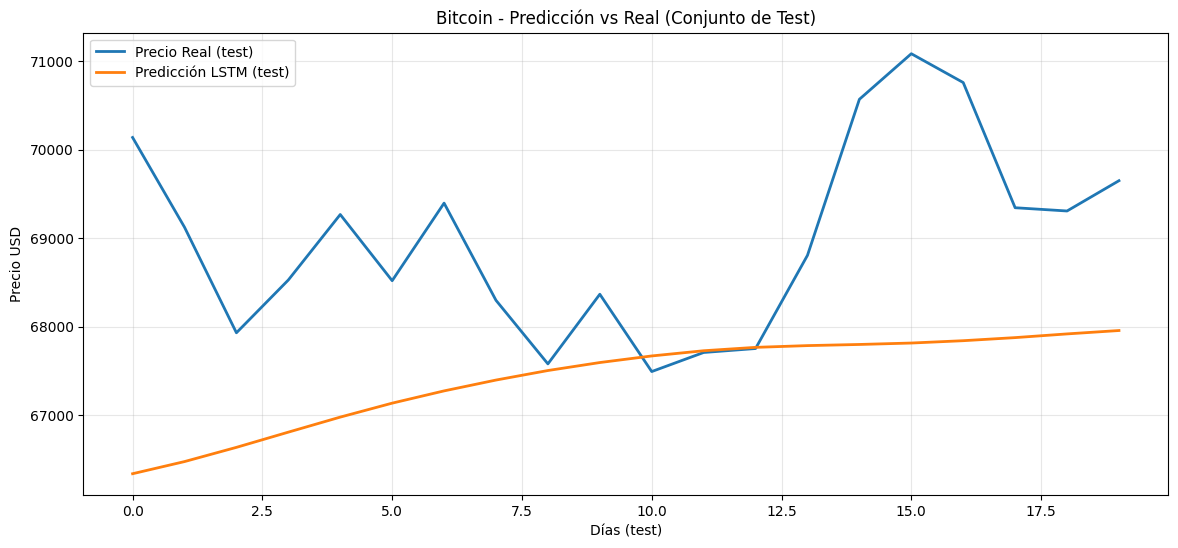

In [10]:
# CELDA 10 - GRÁFICO: TEST real vs predicción
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Precio Real (test)', linewidth=2)
plt.plot(predictions, label='Predicción LSTM (test)', linewidth=2)
plt.title('Bitcoin - Predicción vs Real (Conjunto de Test)')
plt.xlabel('Días (test)')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [11]:
# CELDA 11 - PREDICCIÓN FUTURA AUTOREGRESIVA (30 días)
days_to_predict = 30
future_predictions = []

# Partimos de la última ventana real (escalada)
current_batch = scaled_data[-window_size:].reshape((1, window_size, len(features)))

# Tomamos la última fila real para rellenar las features no-close en cada paso
last_real_row = scaled_data[-1].copy()  # vector escalado (open,high,low,close,volume)

for i in range(days_to_predict):
    # predecir close escalado para el siguiente día
    next_pred = model.predict(current_batch, verbose=0)[0,0]
    future_predictions.append(next_pred)

    # construir nueva fila escalada: usamos last_real_row para las otras columnas (más estable que ceros)
    new_row = last_real_row.copy()
    new_row[3] = next_pred   # reemplazamos la columna 'close' por la predicción escalada

    # desplazar la ventana y añadir la nueva fila (shape mantiene (1, window_size, n_features))
    current_batch = np.concatenate([current_batch[:,1:,:], new_row.reshape(1,1,len(features))], axis=1)

# desescalar solo close para las predicciones futuras
future_full = np.zeros((len(future_predictions), len(features)))
future_full[:, 3] = np.array(future_predictions)
future_pred_inv = scaler.inverse_transform(future_full)[:, 3]

print("Predicción futura (30 días) generada.")


Predicción futura (30 días) generada.


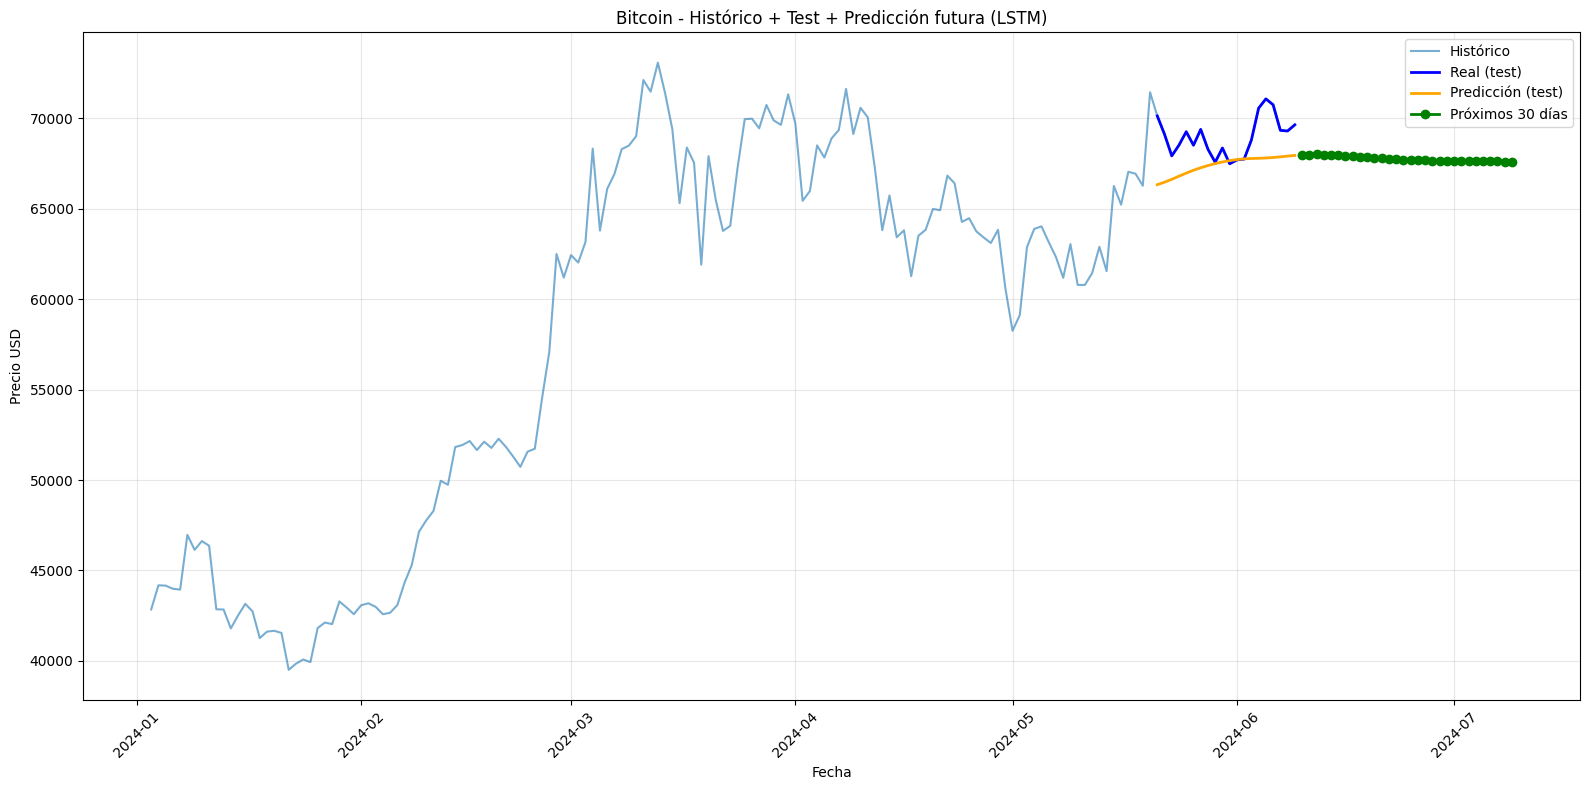


Predicción Bitcoin dentro de 30 días → $67,617 USD


In [12]:
# CELDA 12 - GRÁFICO FINAL: histórico + test + predicción futura
last_dates = pd.to_datetime(df_raw['timeOpen'].iloc[-len(y_test_inv):])
future_dates = pd.date_range(start=last_dates.iloc[-1] + pd.Timedelta(days=1), periods=days_to_predict)

plt.figure(figsize=(16,8))
plt.plot(pd.to_datetime(df_raw['timeOpen']), df_raw['close'], label='Histórico', alpha=0.6)
plt.plot(last_dates, y_test_inv, label='Real (test)', color='blue', linewidth=2)
plt.plot(last_dates, predictions, label='Predicción (test)', color='orange', linewidth=2)
plt.plot(future_dates, future_pred_inv, label=f'Próximos {days_to_predict} días', color='green', marker='o', linewidth=2)

plt.title('Bitcoin - Histórico + Test + Predicción futura (LSTM)')
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nPredicción Bitcoin dentro de {days_to_predict} días → ${future_pred_inv[-1]:,.0f} USD")
